<a href="https://colab.research.google.com/github/Pranjalya/fake-news-twitter/blob/master/Fake_News_Countering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using Spark

Installing dependencies (JAVA, Hadoop and Spark)

In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!pip install -q findspark
!pip install -q pyspark
!pip install -q tweet-preprocessor

Creating Spark session using PySpark

In [0]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

Downloading fact-checking twitter data.

In [3]:
!curl 'https://storage.googleapis.com/kaggle-data-sets/689642%2F1213945%2Fcompressed%2FAllTweets_Dec2019_June2020.csv.zip?GoogleAccessId=gcp-kaggle-com@kaggle-161607.iam.gserviceaccount.com&Expires=1591776960&Signature=lOPPi5k%2FlvyJT8uawwMzZsSZ1m%2B2XT2ti%2BMWBQzXcAj5zPbsMepoaGfQ2pRYai3aZEAc9R9R8Y8BtSYKP5fEfwpN1SyOaRtYcU%2BsqnK7xWVqc5cNYl3sBzOiYBZDOA1DnaopD213MF1EjNtdcg3tFzbZ9X%2FReXzEuHShkPtFjfWudnchNRNKkMpLw5twvLxFtyrWt4tMlTdLo7E35AdDedW%2FEoBC1dOGUvGrdg3%2Feh%2F6B0H7WM25i79%2FblRU5Ef7oU%2F5lfMUeNFfEpuxmOdvsq8jvlAxUAS5FXpKvFVvmBPawEBAnkp6p9LYyOg3unAaHLLGQVxQAQdFzTVtUt8o6Q%3D%3D' -H 'authority: storage.googleapis.com' -H 'upgrade-insecure-requests: 1' -H 'dnt: 1' -H 'user-agent: Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/80.0.3987.132 Safari/537.36' -H 'sec-fetch-dest: document' -H 'accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9' -H 'sec-fetch-site: cross-site' -H 'sec-fetch-mode: navigate' -H 'sec-fetch-user: ?1' -H 'referer: https://www.kaggle.com/' -H 'accept-language: en-IN,en-GB;q=0.9,en-US;q=0.8,en;q=0.7' --compressed --output fact_checker.zip
!mkdir data
!unzip fact_checker.zip -d data -n

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 10.1M  100 10.1M    0     0  30.8M      0 --:--:-- --:--:-- --:--:-- 30.7M
mkdir: cannot create directory ‘data’: File exists
Archive:  fact_checker.zip
replace data/AllTweets_Dec2019_June2020.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


## Loading data

In [32]:
import pandas as pd
import numpy as np
import os
import re
# Tweet preprocessor - https://github.com/s/preprocessor
import preprocessor as tp
import nltk
import string
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from tqdm import tqdm

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS
from sklearn.metrics import silhouette_score
from sklearn.externals import joblib
from sklearn.manifold import TSNE

# Visualization
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
from matplotlib import animation

from sklearn.manifold import MDS

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
path = '/content/drive/My Drive/twitter_dataset/'
fact_checker_path = '/content/data/AllTweets_Dec2019_June2020.csv'
first = True

for f in tqdm(os.listdir(path)):
    if(first):
        df = pd.read_json(path + f, compression='gzip', lines=True)
        fact_checker_df = pd.read_csv(fact_checker_path)
        first = True
    else:
        df = pd.concat([df, pd.read_json(path + f, compression='gzip', lines=True)])
df = df.loc[df.astype(str).drop_duplicates().index]
df.info()

  0%|          | 0/90 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (5,20) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
100%|██████████| 90/90 [02:46<00:00,  1.85s/it]


<class 'pandas.core.frame.DataFrame'>
Int64Index: 15686 entries, 0 to 15685
Data columns (total 33 columns):
 #   Column                     Non-Null Count  Dtype              
---  ------                     --------------  -----              
 0   created_at                 15686 non-null  datetime64[ns, UTC]
 1   id                         15686 non-null  int64              
 2   id_str                     15686 non-null  int64              
 3   full_text                  15686 non-null  object             
 4   truncated                  15686 non-null  bool               
 5   display_text_range         15686 non-null  object             
 6   entities                   15686 non-null  object             
 7   source                     15686 non-null  object             
 8   in_reply_to_status_id      839 non-null    float64            
 9   in_reply_to_status_id_str  839 non-null    float64            
 10  in_reply_to_user_id        882 non-null    float64            
 11  in

In [6]:
fact_checker_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85622 entries, 0 to 85621
Data columns (total 34 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               85622 non-null  int64  
 1   conversation_id  85622 non-null  int64  
 2   created_at       85622 non-null  int64  
 3   date             85622 non-null  object 
 4   timezone         85622 non-null  object 
 5   place            4 non-null      object 
 6   tweet            85622 non-null  object 
 7   hashtags         85622 non-null  object 
 8   cashtags         85622 non-null  object 
 9   user_id          85622 non-null  int64  
 10  user_id_str      85622 non-null  int64  
 11  username         85622 non-null  object 
 12  name             85622 non-null  object 
 13  day              85622 non-null  int64  
 14  hour             85622 non-null  int64  
 15  link             85622 non-null  object 
 16  retweet          85622 non-null  bool   
 17  nlikes      

In [7]:
df.head()

,created_at,id,id_str,full_text,truncated,display_text_range,entities,source,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,in_reply_to_screen_name,user,geo,coordinates,place,contributors,retweeted_status,is_quote_status,retweet_count,favorite_count,favorited,retweeted,lang,extended_entities,possibly_sensitive,quoted_status_id,quoted_status_id_str,quoted_status_permalink,quoted_status,withheld_scope,withheld_in_countries
0,2020-01-23 18:59:28+00:00,1220420803336048642,1220420803336048640,RT @ConflictsW: Roads in Wuhan on lockdown and...,False,"[0, 140]","{'hashtags': [{'text': 'China', 'indices': [99...","<a href=""http://twitter.com/download/iphone"" r...",NaN,NaN,NaN,NaN,None,"{'id': 12537532, 'id_str': '12537532', 'name':...",None,None,None,NaN,{'created_at': 'Wed Jan 22 19:44:32 +0000 2020...,False,7443,0,False,False,en,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-01-23 18:59:28+00:00,1220420805189931009,1220420805189931008,RT @BNODesk: Here's a current list of the coro...,False,"[0, 140]","{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,NaN,NaN,NaN,None,"{'id': 624000012, 'id_str': '624000012', 'name...",None,None,None,NaN,{'created_at': 'Thu Jan 23 18:02:45 +0000 2020...,False,353,0,False,False,en,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-01-23 18:59:29+00:00,1220420806104289286,1220420806104289280,RT @ScottPresler: Is anyone else following the...,False,"[0, 140]","{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""http://twitter.com/download/iphone"" r...",NaN,NaN,NaN,NaN,None,"{'id': 39666288, 'id_str': '39666288', 'name':...",None,None,None,NaN,{'created_at': 'Thu Jan 23 18:32:48 +0000 2020...,False,1241,0,False,False,en,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-01-23 18:59:29+00:00,1220420808985718785,1220420808985718784,RT @JackPosobiec: Huge \n\nWas just told by a ...,False,"[0, 139]","{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""http://twitter.com/download/iphone"" r...",NaN,NaN,NaN,NaN,None,"{'id': 1080984630331957249, 'id_str': '1080984...",None,None,None,NaN,{'created_at': 'Thu Jan 23 18:22:14 +0000 2020...,False,1161,0,False,False,en,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-01-23 18:59:30+00:00,1220420812123115520,1220420812123115520,RT @inteldotwav: Helpful diagram by the WHO sh...,False,"[0, 123]","{'hashtags': [{'text': 'coronavirus', 'indices...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,NaN,NaN,NaN,None,"{'id': 43403644, 'id_str': '43403644', 'name':...",None,None,None,NaN,{'created_at': 'Thu Jan 23 18:52:04 +0000 2020...,False,141,0,False,False,en,"{'media': [{'id': 1220418936216412160, 'id_str...",0.0,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
fact_checker_df.head()

,id,conversation_id,created_at,date,timezone,place,tweet,hashtags,cashtags,user_id,user_id_str,username,name,day,hour,link,retweet,nlikes,nreplies,nretweets,quote_url,search,near,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest,Region
0,1267487446809313282,1267487446809313282,1591027530000,2020-06-01 16:05:30,UTC,NaN,"Aarti Lalchandani, principal of GVSM Medical C...",['#altnewsfactcheck'],[],717020664587227136,717020664587227136,AltNews,Alt News,1,16,https://twitter.com/AltNews/status/12674874468...,False,811,40,373,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '717020664587227136', 'username':...",NaN,NaN,NaN,NaN,Others
1,1267108282164019202,1267108282164019202,1590937130000,2020-05-31 14:58:50,UTC,NaN,Times Now played three videos during a show on...,['#altnewsfactcheck'],[],717020664587227136,717020664587227136,AltNews,Alt News,7,14,https://twitter.com/AltNews/status/12671082821...,False,278,9,92,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '717020664587227136', 'username':...",NaN,NaN,NaN,NaN,Others
2,1266732527227744256,1266732527227744256,1590847543000,2020-05-30 14:05:43,UTC,NaN,A video of an incident from Surat has been sha...,['#altnewsfactcheck'],[],717020664587227136,717020664587227136,AltNews,Alt News,6,14,https://twitter.com/AltNews/status/12667325272...,False,148,1,56,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '717020664587227136', 'username':...",NaN,NaN,NaN,NaN,Others
3,1266671072671391744,1266671072671391744,1590832891000,2020-05-30 10:01:31,UTC,NaN,A video showing poor condition of Mumbai's KEM...,['#altnewsfactcheck'],[],717020664587227136,717020664587227136,AltNews,Alt News,6,10,https://twitter.com/AltNews/status/12666710726...,False,157,5,64,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '717020664587227136', 'username':...",NaN,NaN,NaN,NaN,Others
4,1266653343767597057,1266653343767597057,1590828665000,2020-05-30 08:51:05,UTC,NaN,"Criticising journalists on COVID-19 reporting,...",['#altnewsfactcheck'],[],717020664587227136,717020664587227136,AltNews,Alt News,6,8,https://twitter.com/AltNews/status/12666533437...,False,439,25,196,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '717020664587227136', 'username':...",NaN,NaN,NaN,NaN,Others


Let's take a look at the sentences of the fact-checker tweets, and see the term it uses to check the news.

In [9]:
fact_checker_df.iloc[6000:6005]

,id,conversation_id,created_at,date,timezone,place,tweet,hashtags,cashtags,user_id,user_id_str,username,name,day,hour,link,retweet,nlikes,nreplies,nretweets,quote_url,search,near,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest,Region
6000,1263425998717980675,1263425998717980675,1590059206000,2020-05-21 11:06:46,UTC,NaN,A video showing a crowded market in Pakistan's...,"['#lockdown', '#covid19', '#fakenews']",[],2392031700,2392031700,boomlive_in,BOOM Live,4,11,https://twitter.com/boomlive_in/status/1263425...,False,14,1,3,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '2392031700', 'username': 'boomli...",NaN,NaN,NaN,NaN,Others
6001,1263422145314484225,1263055756393189376,1590058287000,2020-05-21 10:51:27,UTC,NaN,https://www.boomlive.in/fake-news/video-from-...,[],[],2392031700,2392031700,boomlive_in,BOOM Live,4,10,https://twitter.com/boomlive_in/status/1263422...,False,1,0,1,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '2392031700', 'username': 'boomli...",NaN,NaN,NaN,NaN,Others
6002,1263422118047309824,1239943348896428032,1590058280000,2020-05-21 10:51:20,UTC,NaN,https://www.boomlive.in/fake-news/video-from-...,[],[],2392031700,2392031700,boomlive_in,BOOM Live,4,10,https://twitter.com/boomlive_in/status/1263422...,False,1,0,0,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '2392031700', 'username': 'boomli...",NaN,NaN,NaN,NaN,Others
6003,1263422038632361984,1263165564123398144,1590058261000,2020-05-21 10:51:01,UTC,NaN,https://www.boomlive.in/fake-news/video-from-...,[],[],2392031700,2392031700,boomlive_in,BOOM Live,4,10,https://twitter.com/boomlive_in/status/1263422...,False,1,0,0,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '2392031700', 'username': 'boomli...",NaN,NaN,NaN,NaN,Others
6004,1263421878414094337,1263079795773956097,1590058223000,2020-05-21 10:50:23,UTC,NaN,https://www.boomlive.in/fake-news/video-from-...,[],[],2392031700,2392031700,boomlive_in,BOOM Live,4,10,https://twitter.com/boomlive_in/status/1263421...,False,2,1,0,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '2392031700', 'username': 'boomli...",NaN,NaN,NaN,NaN,Others


At the end of each fact-checking tweet, there's a link to actual blog, on which the results of the claims are published. Keeping them in a seperate field, as they would get removed in preprocessing.

In [0]:
fact_checker_df['relay_url'] = fact_checker_df['tweet'].str.extract(
    pat="(http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+)")

## Data Preprocessing

Getting all the list of emoticons and other pictorials first.

In [0]:
emoticons_happy = set([
    ':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}',
    ':^)', ':-D', ':D', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D',
    '=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:P', ':-P', ':P', 'X-P',
    'x-p', 'xp', 'XP', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)',
    '<3'
    ])

emoticons_sad = set([
    ':L', ':-/', '>:/', ':S', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<',
    ':-[', ':-<', '=\\', '=/', '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c',
    ':c', ':{', '>:\\', ';('
    ])

#Emoji patterns
emoji_pattern = re.compile("["
         u"\U0001F600-\U0001F64F"  # emoticons
         u"\U0001F300-\U0001F5FF"  # symbols & pictographs
         u"\U0001F680-\U0001F6FF"  # transport & map symbols
         u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
         u"\U00002702-\U000027B0"
         u"\U000024C2-\U0001F251"
         "]+", flags=re.UNICODE)

# All emoticons
emoticons = emoticons_happy.union(emoticons_sad)

Performing basic preprocessings.

In [0]:
def clean_tweets(tweet):
 
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(tweet)

    # Removing retweets and 
    tweet = re.sub(r'RT', '', tweet)
    tweet = re.sub(r':', '', tweet)
    tweet = re.sub(r'‚Ä¶', '', tweet)

    # Replace=ing consecutive non-ASCII characters with a space
    tweet = re.sub(r'[^\x00-\x7F]+',' ', tweet)

    # Removing emoticons from tweet
    tweet = emoji_pattern.sub(r'', tweet)

    # Filtering using NLTK library append it to a string
    filtered_tweet = [w for w in word_tokens if not w in stop_words]
    filtered_tweet = []

    for w in word_tokens:
        if w not in stop_words and w not in emoticons and w not in string.punctuation:
            filtered_tweet.append(w)
    
    return ' '.join(filtered_tweet)

Cleaning all the tweets.

In [13]:
%%time
# Cleaning using tweet-preprocessor tool first
df['full_text'] = [tp.clean(x) for x in df['full_text']]

# Performing some extra custom cleaning steps
df['full_text'] = [clean_tweets(x) for x in df['full_text']]

# Performing cleaning too fact-checking tweets
fact_checker_df['tweet'] = [tp.clean(x) for x in fact_checker_df['tweet']]
fact_checker_df['tweet'] = [clean_tweets(x) for x in fact_checker_df['tweet']]

CPU times: user 52.7 s, sys: 1.5 s, total: 54.2 s
Wall time: 54.3 s


In [14]:
df.head()

,created_at,id,id_str,full_text,truncated,display_text_range,entities,source,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,in_reply_to_screen_name,user,geo,coordinates,place,contributors,retweeted_status,is_quote_status,retweet_count,favorite_count,favorited,retweeted,lang,extended_entities,possibly_sensitive,quoted_status_id,quoted_status_id_str,quoted_status_permalink,quoted_status,withheld_scope,withheld_in_countries
0,2020-01-23 18:59:28+00:00,1220420803336048642,1220420803336048640,Roads Wuhan lockdown blocked police city quara...,False,"[0, 140]","{'hashtags': [{'text': 'China', 'indices': [99...","<a href=""http://twitter.com/download/iphone"" r...",NaN,NaN,NaN,NaN,None,"{'id': 12537532, 'id_str': '12537532', 'name':...",None,None,None,NaN,{'created_at': 'Wed Jan 22 19:44:32 +0000 2020...,False,7443,0,False,False,en,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-01-23 18:59:28+00:00,1220420805189931009,1220420805189931008,Here 's current list coronavirus lockdowns Wuh...,False,"[0, 140]","{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,NaN,NaN,NaN,None,"{'id': 624000012, 'id_str': '624000012', 'name...",None,None,None,NaN,{'created_at': 'Thu Jan 23 18:02:45 +0000 2020...,False,353,0,False,False,en,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-01-23 18:59:29+00:00,1220420806104289286,1220420806104289280,Is anyone else following Coronavirus outbreak ...,False,"[0, 140]","{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""http://twitter.com/download/iphone"" r...",NaN,NaN,NaN,NaN,None,"{'id': 39666288, 'id_str': '39666288', 'name':...",None,None,None,NaN,{'created_at': 'Thu Jan 23 18:32:48 +0000 2020...,False,1241,0,False,False,en,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-01-23 18:59:29+00:00,1220420808985718785,1220420808985718784,Huge Was told Chinese reporter CCP authorities...,False,"[0, 139]","{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""http://twitter.com/download/iphone"" r...",NaN,NaN,NaN,NaN,None,"{'id': 1080984630331957249, 'id_str': '1080984...",None,None,None,NaN,{'created_at': 'Thu Jan 23 18:22:14 +0000 2020...,False,1161,0,False,False,en,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-01-23 18:59:30+00:00,1220420812123115520,1220420812123115520,Helpful diagram WHO showing various symptoms W...,False,"[0, 123]","{'hashtags': [{'text': 'coronavirus', 'indices...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,NaN,NaN,NaN,None,"{'id': 43403644, 'id_str': '43403644', 'name':...",None,None,None,NaN,{'created_at': 'Thu Jan 23 18:52:04 +0000 2020...,False,141,0,False,False,en,"{'media': [{'id': 1220418936216412160, 'id_str...",0.0,NaN,NaN,NaN,NaN,NaN,NaN


## Clustering Twitter data

First, we transform textual data into vectors based on tf-idf algorithm.

In [52]:
# Defining tf-idf vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(use_idf=True, ngram_range=(1,3))

# Creating tf-idf matrix
%time tfidf_matrix = tfidf_vectorizer.fit_transform(df['full_text']) #fit the vectorizer to synopses

print(tfidf_matrix.shape)

CPU times: user 842 ms, sys: 19.1 ms, total: 861 ms
Wall time: 862 ms
(15686, 90506)


`terms` is just a list of the features used in the tf-idf matrix. This is a vocabulary.

In [0]:
terms = tfidf_vectorizer.get_feature_names()
print(terms)

`dist` is used to determine the similarity between the tweets based on cosine-similarity.

In [0]:
normalized_vectors = preprocessing.normalize(tfidf_matrix)
scores = [KMeans(n_clusters=i+2).fit(normalized_vectors).inertia_ for i in range(10)]

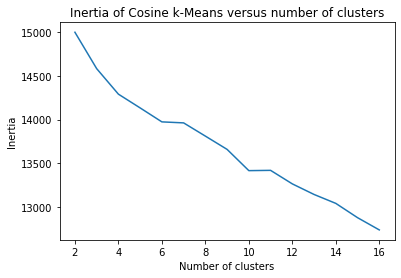

In [25]:
sns.lineplot(np.arange(2, 17), scores)
plt.xlabel('Number of clusters')
plt.ylabel("Inertia")
plt.title("Inertia of Cosine k-Means versus number of clusters")
plt.savefig("intertia_cosine_kmeans.jpg", dpi=300)

7 seems to be a good number.

In [26]:
# Prepare models
kmeans = KMeans(n_clusters=7).fit(tfidf_matrix)
normalized_vectors = preprocessing.normalize(tfidf_matrix)
normalized_kmeans = KMeans(n_clusters=7).fit(normalized_vectors)

## DBSCAN and OPTICS, though good clustering algorithms, weren't able to process the data,
## DBSCAN got labels as -1 only, and
## OPTICS was unable to load in Colab because it doesn't take Sparse Matrix

# min_samples = tfidf_matrix.shape[1]+1 
# dbscan = DBSCAN(eps=3.5, min_samples=min_samples).fit(tfidf_matrix)
# optics = OPTICS(min_samples=min_samples).fit(tfidf_matrix.toarray())

# Print results
print('kmeans: {}'.format(silhouette_score(tfidf_matrix, kmeans.labels_, 
                                           metric='euclidean')))
print('Cosine kmeans:{}'.format(silhouette_score(normalized_vectors,
                                          normalized_kmeans.labels_,
                                          metric='cosine')))

kmeans: 0.10280462821708301
Cosine kmeans:0.09811636140268562


In [28]:
# Saving the models
joblib.dump(kmeans, 'kmeans.pkl')
joblib.dump(normalized_kmeans, 'norm_kmeans.pkl')

['norm_kmeans.pkl']

Let's see the different information from the clusters.

In [29]:
df['cluster'] = kmeans.labels_.tolist()
df['cluster'].value_counts()

5    12823
6      687
0      564
2      556
4      477
3      299
1      280
Name: cluster, dtype: int64

In [30]:
df['norm_cluster'] = normalized_kmeans.labels_.tolist()
df['norm_cluster'].value_counts()

0    12519
6      879
3      807
2      556
4      437
5      299
1      189
Name: norm_cluster, dtype: int64

Let's take a look at the senetences belonging to diffrent clusters.

In [31]:
print("Top terms per cluster : \n")

kmeans = joblib.load('/content/kmeans.pkl')
clusters = kmeans.labels_.tolist()

num_clusters = 7

#sort cluster centers by proximity to centroid
order = kmeans.cluster_centers_.argsort()[:, ::-1] 

for i in range(1, num_clusters+1):
    print("Cluster {} words:".format(i))
    for text in df[df['cluster']==i]['full_text'][:10]:
        print('{}'.format(text))
    print("\n")

Top terms per cluster : 

Cluster 1 words:
Guan Yi virologist identified SARS '' Ive seen bird flu SARS influenza A swine feve
Guan Yi virologist identified SARS '' Ive seen bird flu SARS influenza A swine feve
Guan Yi virologist identified SARS chilling perspective Wuhan outbreak Ive seen bird flu
Guan Yi virologist identified SARS '' Ive seen bird flu SARS influenza A swine feve
Guan Yi virologist identified SARS '' Ive seen bird flu SARS influenza A swine feve
Guan Yi virologist identified SARS chilling perspective Wuhan outbreak Ive seen bird flu
Guan Yi virologist identified SARS '' Ive seen bird flu SARS influenza A swine feve
Guan Yi virologist identified SARS '' Ive seen bird flu SARS influenza A swine feve
Guan Yi virologist identified SARS chilling perspective Wuhan outbreak Ive seen bird flu
Guan Yi virologist identified SARS '' Ive seen bird flu SARS influenza A swine feve


Cluster 2 words:
Huge Was told Chinese reporter CCP authorities allowing disinformation spread socia

## Visualisation

In [0]:
# From https://github.com/MaartenGr/CustomerSegmentation/blob/master/Customer%20Segmentation.ipynb

def prepare_tsne(n_components, data, kmeans_labels):
    names = ['x', 'y', 'z']
    matrix = TSNE(n_components=n_components).fit_transform(data)
    df_matrix = pd.DataFrame(matrix)
    df_matrix.rename({i:names[i] for i in range(n_components)}, axis=1, inplace=True)
    df_matrix['labels'] = kmeans_labels
    
    return df_matrix

def plot_animation(df, label_column, name):
    def update(num):
        ax.view_init(200, num)

    N=360
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(tsne_3d_df['x'], tsne_3d_df['y'], tsne_3d_df['z'], c=tsne_3d_df[label_column],
               s=6, depthshade=True, cmap='Paired')
    ax.set_zlim(-15, 25)
    ax.set_xlim(-20, 20)
    plt.tight_layout()
    ani = animation.FuncAnimation(fig, update, N, blit=False, interval=50)
    try:
        ani.save('{}.gif'.format(name), writer='imagemagick')
    except:
        print()
    plt.show()

In [0]:
tsne_3d_df = prepare_tsne(3, tfidf_matrix, kmeans.labels_)
tsne_3d_df['normalized_kmeans'] = normalized_kmeans.labels_

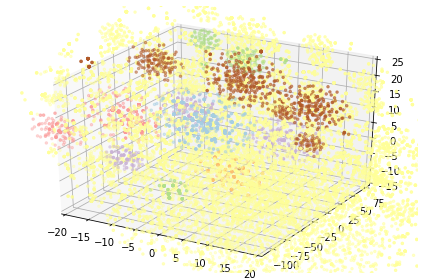

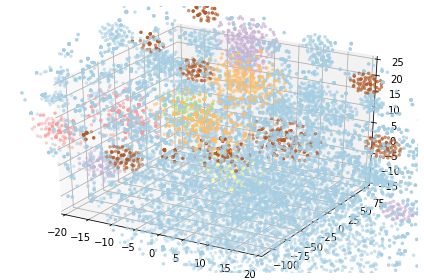

In [47]:
plot_animation(tsne_3d_df, 'labels', 'kmeans')
plot_animation(tsne_3d_df, 'normalized_kmeans', 'normalized_kmeans')

## Map the Fact - Check News

The way would be to : 

-> Get the fact news

-> Convert to sparse matrix

-> Predict the cluster

-> Get the False or True claim from the extracted urls

In [53]:
# Getting a sample news
text = fact_checker_df.iloc[5]['tweet']

## Converting to sparse matrix
%time prediction_matrix = tfidf_vectorizer.transform([text])

CPU times: user 3.27 ms, sys: 80 µs, total: 3.35 ms
Wall time: 4.22 ms


In [54]:
kmeans_model = joblib.load('/content/kmeans.pkl')
predicted = kmeans_model.predict(prediction_matrix)
print(text, " : ", predicted)

In backdrop Cyclone Amphan video landslide occurred Indonesia circulating Guwahati Meghalaya  :  [5]


Let's see which content belong to this cluster.

In [56]:
df[df['cluster']==predicted[0]]

,created_at,id,id_str,full_text,truncated,display_text_range,entities,source,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,in_reply_to_screen_name,user,geo,coordinates,place,contributors,retweeted_status,is_quote_status,retweet_count,favorite_count,favorited,retweeted,lang,extended_entities,possibly_sensitive,quoted_status_id,quoted_status_id_str,quoted_status_permalink,quoted_status,withheld_scope,withheld_in_countries,cluster,norm_cluster
0,2020-01-23 18:59:28+00:00,1220420803336048642,1220420803336048640,Roads Wuhan lockdown blocked police city quara...,False,"[0, 140]","{'hashtags': [{'text': 'China', 'indices': [99...","<a href=""http://twitter.com/download/iphone"" r...",NaN,NaN,NaN,NaN,None,"{'id': 12537532, 'id_str': '12537532', 'name':...",None,None,None,NaN,{'created_at': 'Wed Jan 22 19:44:32 +0000 2020...,False,7443,0,False,False,en,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,0
1,2020-01-23 18:59:28+00:00,1220420805189931009,1220420805189931008,Here 's current list coronavirus lockdowns Wuh...,False,"[0, 140]","{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,NaN,NaN,NaN,None,"{'id': 624000012, 'id_str': '624000012', 'name...",None,None,None,NaN,{'created_at': 'Thu Jan 23 18:02:45 +0000 2020...,False,353,0,False,False,en,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,4
4,2020-01-23 18:59:30+00:00,1220420812123115520,1220420812123115520,Helpful diagram WHO showing various symptoms W...,False,"[0, 123]","{'hashtags': [{'text': 'coronavirus', 'indices...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,NaN,NaN,NaN,None,"{'id': 43403644, 'id_str': '43403644', 'name':...",None,None,None,NaN,{'created_at': 'Thu Jan 23 18:52:04 +0000 2020...,False,141,0,False,False,en,"{'media': [{'id': 1220418936216412160, 'id_str...",0.0,NaN,NaN,NaN,NaN,NaN,NaN,5,0
5,2020-01-23 18:59:31+00:00,1220420814518018048,1220420814518018048,Breaking Brazos County Health Authority Brazos...,False,"[0, 140]","{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""https://about.twitter.com/products/tw...",NaN,NaN,NaN,NaN,None,"{'id': 39860280, 'id_str': '39860280', 'name':...",None,None,None,NaN,{'created_at': 'Thu Jan 23 18:59:15 +0000 2020...,False,39,0,False,False,en,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,0
6,2020-01-23 18:59:31+00:00,1220420814983528449,1220420814983528448,And biggest bio-lab chinese Wuhan,False,"[0, 119]","{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""http://twitter.com/#!/download/ipad"" ...",NaN,NaN,NaN,NaN,None,"{'id': 221023583, 'id_str': '221023583', 'name...",None,None,None,NaN,{'created_at': 'Wed Jan 22 19:14:22 +0000 2020...,False,18,0,False,False,en,"{'media': [{'id': 1220062157649301504, 'id_str...",0.0,NaN,NaN,NaN,NaN,NaN,NaN,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15681,2020-01-23 18:15:48+00:00,1220409814758707212,1220409814758707200,Tell Ebola eating bats monkeys,False,"[25, 102]","{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""https://mobile.twitter.com"" rel=""nofo...",1.220407e+18,1.220407e+18,7.812107e+17,7.812107e+17,janicebayless,"{'id': 958432492847095808, 'id_str': '95843249...",None,None,None,NaN,NaN,False,0,1,False,False,en,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,5,0
15682,2020-01-23 18:33:21+00:00,1220414231218204673,1220414231218204672,If people fact infected acting responsibly tim...,False,"[0, 140]","{'hashtags': [{'text': 'China', 'indices': [61...","<a href=""http://twitter.com/#!/download/ipad"" ...",NaN,NaN,NaN,NaN,None,"{'id': 703570340, 'id_str': '703570340', 'name...",None,None,None,NaN,{'created_at': 'Thu Jan 23 13:11:58 +0000 2020...,True,1361,0,False,False,en,NaN,NaN,1.220139e+18,1.220139e+18,"{'url': 'https://t.co/wKQs0k8BW6', 'expanded':...",NaN,NaN,NaN,5,0
15683,2020-01-23 18:54:46+00:00,1220419620638687232,1220419620638687232,If people fact infected acting respon